In [23]:
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import subprocess
import select
import time
import re
import os
import sys
import glob

# GLOBAL VARIABLES
# Number of experimental runs to average together
num_experimental_runs = 1
# Amount to increment the port number by for each experiment
port_inc = 0
# Data directory
data_dir = '/tmp/'

def start_server(error_rate, num_pages, fanout, level_policy, port):
    global port_inc
    while True:
        cmd = f"./bin/server -e {error_rate} -n {num_pages} -f {fanout} -l {level_policy} -p {port}"
        server_process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        print(f"Starting the server on port {port}")

        # Read only the first line of stderr
        error_line = server_process.stderr.readline().decode()
        print(error_line, end="")
        sys.stdout.flush()

        if "Error binding server socket" in error_line:
            server_process.terminate()
            port += 1
            port_inc += 1
        else:
            return server_process

def stop_server(server_process):
    server_process.terminate()

def delete_lsm_files():
    global data_dir
    lsm_files = glob.glob(data_dir + 'lsm-*')
    for file in lsm_files:
        try:
            os.remove(file)
        except OSError:
            print(f"Error: Unable to delete file: {file}")

In [24]:
# Alternate code in case I need it - had some blocking issues
# def wait_for_server_ready(server_process):
#     start_time = time.time()
#     timeout = 60  # Timeout in seconds

#     while True:
#         ready, _, _ = select.select([server_process.stdout], [], [], timeout)
#         if ready:
#             output_line = server_process.stdout.readline().decode()
#             print(output_line, end="")
#             if "New client connected" in output_line:
#                 break
#         elif time.time() - start_time > timeout:
#             raise TimeoutError("Server did not print 'New client connected' within the timeout period.")

def wait_for_server_ready(server_process):
    start_time = time.time()
    timeout = 600  # Timeout in seconds

    for output_line in iter(server_process.stdout.readline, b''):
        output_line = output_line.decode()
        print(output_line, end="")
        sys.stdout.flush()
        if "New client connected" in output_line:
            break
        elif time.time() - start_time > timeout:
            raise TimeoutError("Server did not print 'New client connected' within the timeout period.")


def run_experiment(port, workload_path, server_process):
    client_cmd = f'./bin/client -p {port}'
    
    # Start the client process
    client_process = subprocess.Popen(client_cmd.split(), stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    
    # Wait for the server to print "New client connected"
    try:
        wait_for_server_ready(server_process)
    except TimeoutError as e:
        print(e)
        client_process.terminate()
        return None

    # Run the benchmark command
    benchmark_cmd = f'b {workload_path}\n'
    client_process.stdin.write(benchmark_cmd.encode())
    client_process.stdin.flush()

    time_taken = None
    num_io_ops = None
    while True:
        # Wait for output from the server process
        ready, _, _ = select.select([server_process.stdout], [], [], 60)  # timeout
        if ready:
            output_line = server_process.stdout.readline().decode()
            match = re.search(r'(\d+) microseconds.*?(\d+) I/O operations', output_line)
            if match:
                time_taken = int(match.group(1))
                num_io_ops = int(match.group(2))
                print(output_line, end="")
                sys.stdout.flush()
                break

    client_process.terminate()
    return time_taken, num_io_ops


In [25]:
def run_experiments(params):
    global port_inc
    global num_experimental_runs
    results = []

    delete_lsm_files()

    for (error_rate, num_pages, fanout, level_policy) in itertools.product(params['error_rate'], params['num_pages'], params['fanout'], params['level_policy']):
        for run in range(num_experimental_runs):
            server_process = start_server(error_rate, num_pages, fanout, level_policy, params['port'] + port_inc)
            time_taken, num_io_ops = run_experiment(params['port'] + port_inc, '10mil.txt', server_process)
            port_inc = port_inc + 1
            stop_server(server_process)

            result = {
                'error_rate': error_rate,
                'num_pages': num_pages,
                'fanout': fanout,
                'level_policy': level_policy,
                'time_taken': time_taken,
                'num_io_ops': num_io_ops,
                'run': run
            }
            results.append(result)

    results_df = pd.DataFrame(results)
    return results_df

# Experiment 1

In [3]:
params = {
    'error_rate': [0.00001],
    'num_pages': [256, 512, 1024],
    'fanout': [2, 5, 10],
    'level_policy': ['LAZY_LEVELED', 'LEVELED', 'TIERED'],
    'port': 1249
}

results_df = run_experiments(params)

Starting the server on port 1249
No file data/lsm-tree.json found or unable to open it. Creating fresh database.

Server started, listening on port 1249
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 524288
  LSM-tree fanout: 2
  Level policy: LAZY_LEVELED
  Verbosity: off

LSM Tree ready and waiting for input
New client connected
Benchmark: Workload workload.txt file took 99713 microseconds (0 minutes, 0.10 seconds) and 0 I/O operations
Starting the server on port 1250
No file data/lsm-tree.json found or unable to open it. Creating fresh database.

Server started, listening on port 1250
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 524288
  LSM-tree fanout: 2
  Level policy: LEVELED
  Verbosity: off

LSM Tree ready and waiting for input
New client connected
Benchmark: Workload workload.txt file took 114776 microseconds (0 minutes, 0.11 seconds) and 0 I/O operations
Starting the server on port 1251
No file data/lsm-tree.jso

  Number of buffer pages: 1048576
  LSM-tree fanout: 10
  Level policy: TIERED
  Verbosity: off

LSM Tree ready and waiting for input
New client connected
Benchmark: Workload workload.txt file took 94137 microseconds (0 minutes, 0.09 seconds) and 0 I/O operations
Starting the server on port 1267
No file data/lsm-tree.json found or unable to open it. Creating fresh database.

Server started, listening on port 1267
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 2097152
  LSM-tree fanout: 2
  Level policy: LAZY_LEVELED
  Verbosity: off

LSM Tree ready and waiting for input
New client connected
Benchmark: Workload workload.txt file took 97914 microseconds (0 minutes, 0.10 seconds) and 0 I/O operations
Starting the server on port 1268
No file data/lsm-tree.json found or unable to open it. Creating fresh database.

Server started, listening on port 1268
LSMTree parameters:
  Bloom filter error rate: 0.01
  Number of buffer pages: 2097152
  LSM-tree fanout: 2
  

Starting the server on port 1284
No file data/lsm-tree.json found or unable to open it. Creating fresh database.

Server started, listening on port 1284
LSMTree parameters:
  Bloom filter error rate: 0.05
  Number of buffer pages: 524288
  LSM-tree fanout: 10
  Level policy: TIERED
  Verbosity: off

LSM Tree ready and waiting for input
New client connected
Benchmark: Workload workload.txt file took 91574 microseconds (0 minutes, 0.09 seconds) and 0 I/O operations
Starting the server on port 1285
No file data/lsm-tree.json found or unable to open it. Creating fresh database.

Server started, listening on port 1285
LSMTree parameters:
  Bloom filter error rate: 0.05
  Number of buffer pages: 1048576
  LSM-tree fanout: 2
  Level policy: LAZY_LEVELED
  Verbosity: off

LSM Tree ready and waiting for input
New client connected
Benchmark: Workload workload.txt file took 97188 microseconds (0 minutes, 0.10 seconds) and 0 I/O operations
Starting the server on port 1286
No file data/lsm-tree.jso

  Number of buffer pages: 2097152
  LSM-tree fanout: 10
  Level policy: LEVELED
  Verbosity: off

LSM Tree ready and waiting for input
New client connected
Benchmark: Workload workload.txt file took 90815 microseconds (0 minutes, 0.09 seconds) and 0 I/O operations
Starting the server on port 1302
No file data/lsm-tree.json found or unable to open it. Creating fresh database.

Server started, listening on port 1302
LSMTree parameters:
  Bloom filter error rate: 0.05
  Number of buffer pages: 2097152
  LSM-tree fanout: 10
  Level policy: TIERED
  Verbosity: off

LSM Tree ready and waiting for input
New client connected
Benchmark: Workload workload.txt file took 89401 microseconds (0 minutes, 0.09 seconds) and 0 I/O operations


In [4]:
results_df

,error_rate,num_pages,fanout,level_policy,time_taken,num_io_ops,run
0,0.01,256,2,LAZY_LEVELED,99713,0,0
1,0.01,256,2,LEVELED,114776,0,0
2,0.01,256,2,TIERED,98143,0,0
3,0.01,256,5,LAZY_LEVELED,100157,0,0
4,0.01,256,5,LEVELED,98523,0,0
5,0.01,256,5,TIERED,98596,0,0
6,0.01,256,10,LAZY_LEVELED,97706,0,0
7,0.01,256,10,LEVELED,94235,0,0
8,0.01,256,10,TIERED,96400,0,0
9,0.01,512,2,LAZY_LEVELED,94471,0,0


In [5]:
for error_rate in params['error_rate']:
    for level_policy in params['level_policy']:
        # Filter the data for the current error rate and level policy combination
        data = results_df[(results_df['error_rate'] == error_rate) & (results_df['level_policy'] == level_policy)]


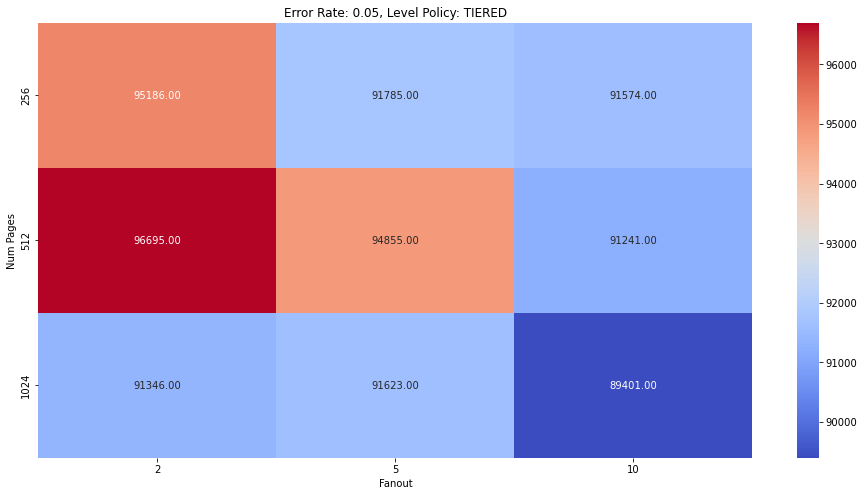

In [6]:
# Create a heatmap of time taken with varying num_pages and fanout values
pivot_table = data.pivot_table(values='time_taken', index='num_pages', columns='fanout')
plt.figure(figsize=(16, 8))

ax = sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='coolwarm')

# Set plot title and labels
ax.set_title(f'Error Rate: {error_rate}, Level Policy: {level_policy}')
ax.set_xlabel('Fanout')
ax.set_ylabel('Num Pages')

# Show the plot
plt.show()


# Experiment 2

In [26]:
params = {
    'error_rate': [0.00001],
    'num_pages': [256, 512, 1024],
    'fanout': [10],
    'level_policy': ['LAZY_LEVELED', 'LEVELED', 'TIERED'],
    'port': 1234
}

results_df = run_experiments(params)

Starting the server on port 1234
No file data/lsm-tree.json found or unable to open it. Creating fresh database.

Server started, listening on port 1234
LSMTree parameters:
  Bloom filter error rate: 1e-05
  Number of buffer pages: 524288
  LSM-tree fanout: 10
  Level policy: LAZY_LEVELED
  Verbosity: off

LSM Tree ready and waiting for input
New client connected
Benchmark: Workload 10mil.txt file took 644345655 microseconds (10 minutes, 44.35 seconds) and 38401941 I/O operations
Starting the server on port 1235
No file data/lsm-tree.json found or unable to open it. Creating fresh database.

Server started, listening on port 1235
LSMTree parameters:
  Bloom filter error rate: 1e-05
  Number of buffer pages: 524288
  LSM-tree fanout: 10
  Level policy: LEVELED
  Verbosity: off

LSM Tree ready and waiting for input
New client connected
Benchmark: Workload 10mil.txt file took 706160566 microseconds (11 minutes, 46.16 seconds) and 61463235 I/O operations
Starting the server on port 1236
No

In [27]:
results_df

,error_rate,num_pages,fanout,level_policy,time_taken,num_io_ops,run
0,0.00001,256,10,LAZY_LEVELED,644345655,38401941,0
1,0.00001,256,10,LEVELED,706160566,61463235,0
2,0.00001,256,10,TIERED,595122774,15341116,0
3,0.00001,512,10,LAZY_LEVELED,144420241,55543566,0
4,0.00001,512,10,LEVELED,141675378,55543566,0
5,0.00001,512,10,TIERED,35287692,9437184,0
6,0.00001,1024,10,LAZY_LEVELED,79523780,27252585,0
7,0.00001,1024,10,LEVELED,78727819,27252585,0
8,0.00001,1024,10,TIERED,35925697,8388608,0


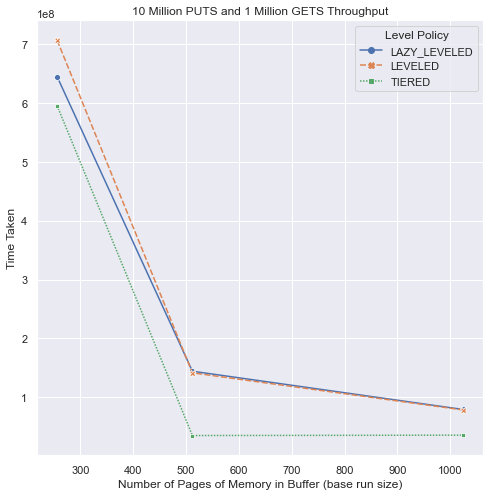

In [49]:
# This plot is too dominated by the page sizes less than 32
sns.set(style="darkgrid")
plt.figure(figsize=(8, 8))

grouped_df = results_df.groupby(["error_rate", "num_pages", "fanout", "level_policy"]).agg({"time_taken": "mean"}).reset_index()

line_plot = sns.lineplot(data=results_df, x="num_pages", y="time_taken", hue="level_policy", style="level_policy", markers=True)

plt.xlabel("Number of Pages of Memory in Buffer (base run size)")
plt.ylabel("Time Taken")
plt.legend(title="Level Policy")
plt.title("10 Million PUTS and 1 Million GETS Throughput")
#plt.yscale("log")  # Set y-axis to logarithmic scale - barely does anything
plt.show()

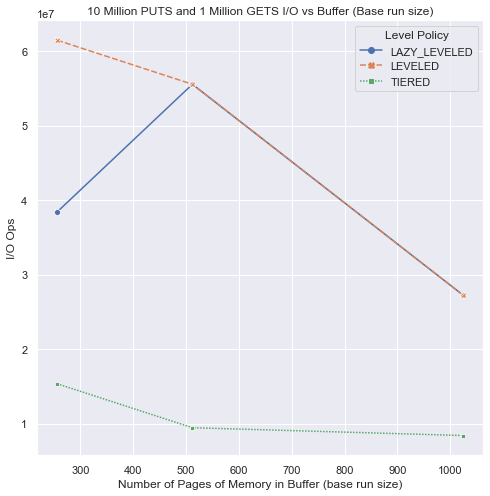

In [51]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 8))

line_plot = sns.lineplot(data=results_df, x="num_pages", y="num_io_ops", hue="level_policy", style="level_policy", markers=True)

plt.xlabel("Number of Pages of Memory in Buffer (base run size)")
plt.ylabel("I/O Ops")
plt.legend(title="Level Policy")
plt.title("10 Million PUTS and 1 Million GETS I/O vs Buffer (Base run size)")
plt.show()

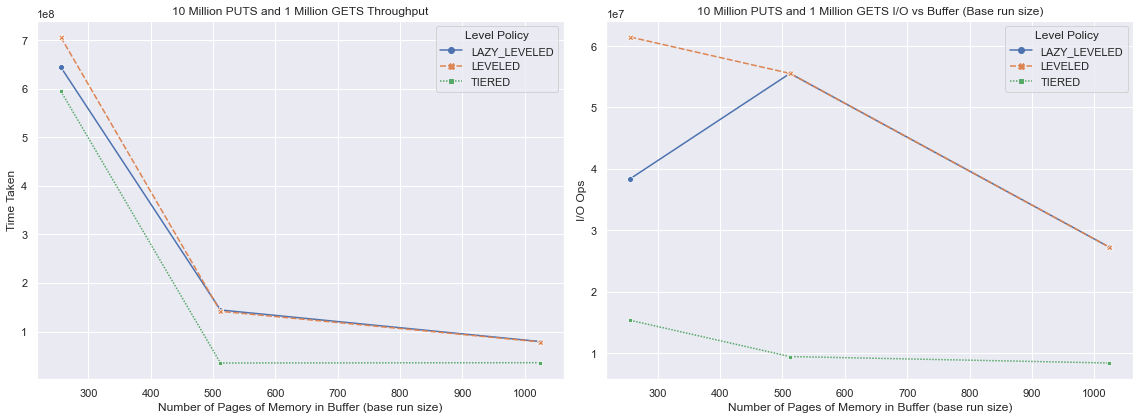

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

grouped_df = results_df.groupby(["error_rate", "num_pages", "fanout", "level_policy"]).agg({"time_taken": "mean"}).reset_index()

# First plot
line_plot = sns.lineplot(ax=axes[0], data=results_df, x="num_pages", y="time_taken", hue="level_policy", style="level_policy", markers=True)

axes[0].set_xlabel("Number of Pages of Memory in Buffer (base run size)")
axes[0].set_ylabel("Time Taken")
axes[0].legend(title="Level Policy")
axes[0].set_title("10 Million PUTS and 1 Million GETS Throughput")

# Second plot
line_plot = sns.lineplot(ax=axes[1], data=results_df, x="num_pages", y="num_io_ops", hue="level_policy", style="level_policy", markers=True)

axes[1].set_xlabel("Number of Pages of Memory in Buffer (base run size)")
axes[1].set_ylabel("I/O Ops")
axes[1].legend(title="Level Policy")
axes[1].set_title("10 Million PUTS and 1 Million GETS I/O vs Buffer (Base run size)")

plt.tight_layout()
plt.show()


# Experiment 3

In [40]:
params = {
    'error_rate': [0.00001],
    'num_pages': [1024],
    'fanout': [2,5,10],
    'level_policy': ['LAZY_LEVELED', 'LEVELED', 'TIERED'],
    'port': 1234
}

results_df2 = run_experiments(params)

Starting the server on port 1243
No file data/lsm-tree.json found or unable to open it. Creating fresh database.

Server started, listening on port 1243
LSMTree parameters:
  Bloom filter error rate: 1e-05
  Number of buffer pages: 2097152
  LSM-tree fanout: 2
  Level policy: LAZY_LEVELED
  Verbosity: off

LSM Tree ready and waiting for input
New client connected
Benchmark: Workload 10mil.txt file took 45763876 microseconds (0 minutes, 45.76 seconds) and 12581849 I/O operations
Starting the server on port 1244
No file data/lsm-tree.json found or unable to open it. Creating fresh database.

Server started, listening on port 1244
LSMTree parameters:
  Bloom filter error rate: 1e-05
  Number of buffer pages: 2097152
  LSM-tree fanout: 2
  Level policy: LEVELED
  Verbosity: off

LSM Tree ready and waiting for input
New client connected
Benchmark: Workload 10mil.txt file took 55052096 microseconds (0 minutes, 55.05 seconds) and 16775138 I/O operations
Starting the server on port 1245
No fil

In [41]:
results_df2

,error_rate,num_pages,fanout,level_policy,time_taken,num_io_ops,run
0,0.00001,1024,2,LAZY_LEVELED,45763876,12581849,0
1,0.00001,1024,2,LEVELED,55052096,16775138,0
2,0.00001,1024,2,TIERED,45321395,12581849,0
3,0.00001,1024,5,LAZY_LEVELED,78958890,27252585,0
4,0.00001,1024,5,LEVELED,78433244,27252585,0
5,0.00001,1024,5,TIERED,37015926,8388608,0
6,0.00001,1024,10,LAZY_LEVELED,80684272,27252585,0
7,0.00001,1024,10,LEVELED,81603897,27252585,0
8,0.00001,1024,10,TIERED,37300943,8388608,0


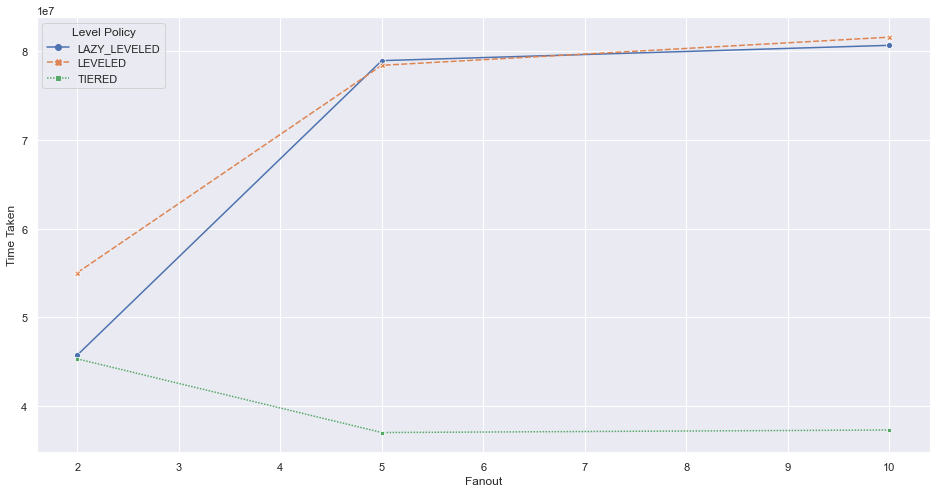

In [42]:
# This plot is too dominated by the page sizes less than 32
sns.set(style="darkgrid")
plt.figure(figsize=(16, 8))

grouped_df = results_df.groupby(["error_rate", "num_pages", "fanout", "level_policy"]).agg({"time_taken": "mean"}).reset_index()

line_plot = sns.lineplot(data=results_df2, x="fanout", y="time_taken", hue="level_policy", style="level_policy", markers=True)

plt.xlabel("Fanout")
plt.ylabel("Time Taken")
plt.legend(title="Level Policy")
#plt.yscale("log")  # Set y-axis to logarithmic scale - barely does anything
plt.show()

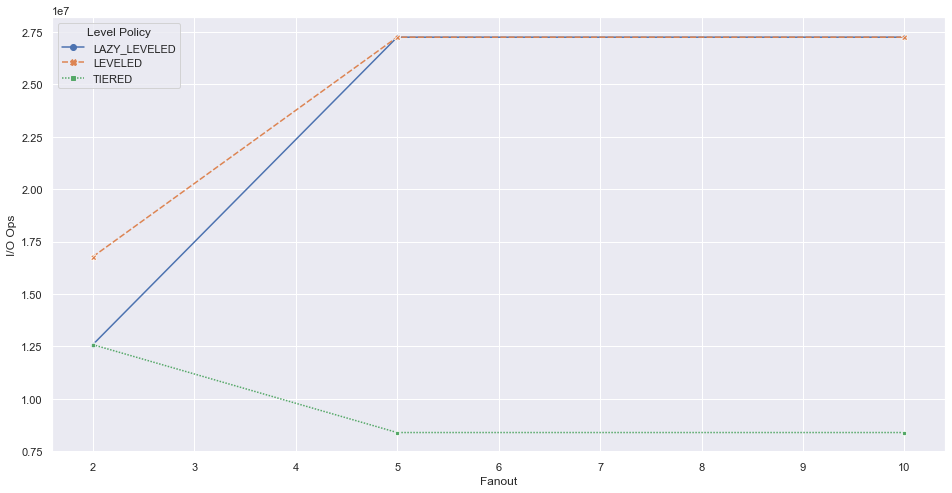

In [43]:
sns.set(style="darkgrid")
plt.figure(figsize=(16, 8))

line_plot = sns.lineplot(data=results_df2, x="fanout", y="num_io_ops", hue="level_policy", style="level_policy", markers=True)

plt.xlabel("Fanout")
plt.ylabel("I/O Ops")
plt.legend(title="Level Policy")
plt.show()